# Adaboost vs. XGBoost: A Comparative Analysis

## Overview

Compare Adaboost vs. XGBoost on classification data using hyperparameter tuning, metrics evaluation, and visualizations.

## Import Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import AdaBoostClassifier
from xgboost import XGBClassifier
from sklearn.metrics import (accuracy_score, precision_score, recall_score, 
                             f1_score, roc_auc_score, confusion_matrix, 
                             roc_curve, classification_report)
import time
import warnings
warnings.filterwarnings('ignore')

plt.style.use('default')
sns.set_palette("husl")

## 1. Dataset Selection

We use the Breast Cancer Wisconsin dataset, a well-known classification dataset with 569 instances and 30 features. The task is to classify tumors as malignant or benign.

In [2]:
data = load_breast_cancer()
X = pd.DataFrame(data.data, columns=data.feature_names)
y = pd.Series(data.target, name='target')

print(f"Dataset shape: {X.shape}")
print(f"Number of features: {X.shape[1]}")
print(f"Number of samples: {X.shape[0]}")
print(f"Target classes: {np.unique(y)}")
print(f"Class distribution:\n{pd.Series(y).value_counts()}")

Dataset shape: (569, 30)
Number of features: 30
Number of samples: 569
Target classes: [0 1]
Class distribution:
target
1    357
0    212
Name: count, dtype: int64


## 2. Data Preprocessing

We check for missing values, handle outliers if necessary, and scale features. Feature scaling is important for optimal model performance.

In [3]:
print("Missing values per column:")
print(X.isnull().sum().sum())

print("\nBasic statistics:")
print(X.describe())

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f"\nTraining samples: {len(X_train)}")
print(f"Test samples: {len(X_test)}")

Missing values per column:
0

Basic statistics:
       mean radius  mean texture  mean perimeter    mean area  \
count   569.000000    569.000000      569.000000   569.000000   
mean     14.127292     19.289649       91.969033   654.889104   
std       3.524049      4.301036       24.298981   351.914129   
min       6.981000      9.710000       43.790000   143.500000   
25%      11.700000     16.170000       75.170000   420.300000   
50%      13.370000     18.840000       86.240000   551.100000   
75%      15.780000     21.800000      104.100000   782.700000   
max      28.110000     39.280000      188.500000  2501.000000   

       mean smoothness  mean compactness  mean concavity  mean concave points  \
count       569.000000        569.000000      569.000000           569.000000   
mean          0.096360          0.104341        0.088799             0.048919   
std           0.014064          0.052813        0.079720             0.038803   
min           0.052630          0.019380  

## 3. Model Implementation

We implement both Adaboost and XGBoost classifiers with default parameters as a baseline.

### 3.1 Adaboost Implementation

In [4]:
ada_model = AdaBoostClassifier(random_state=42)

start_time = time.time()
ada_model.fit(X_train_scaled, y_train)
ada_training_time = time.time() - start_time

ada_train_pred = ada_model.predict(X_train_scaled)
ada_test_pred = ada_model.predict(X_test_scaled)

print(f"Training time: {ada_training_time:.4f} seconds")
print(f"Training accuracy: {accuracy_score(y_train, ada_train_pred):.4f}")
print(f"Test accuracy: {accuracy_score(y_test, ada_test_pred):.4f}")

Training time: 0.1980 seconds
Training accuracy: 1.0000
Test accuracy: 0.9561


### 3.2 XGBoost Implementation

In [5]:
xgb_model = XGBClassifier(random_state=42, eval_metric='logloss')

start_time = time.time()
xgb_model.fit(X_train_scaled, y_train)
xgb_training_time = time.time() - start_time

xgb_train_pred = xgb_model.predict(X_train_scaled)
xgb_test_pred = xgb_model.predict(X_test_scaled)

print(f"Training time: {xgb_training_time:.4f} seconds")
print(f"Training accuracy: {accuracy_score(y_train, xgb_train_pred):.4f}")
print(f"Test accuracy: {accuracy_score(y_test, xgb_test_pred):.4f}")

Training time: 0.1430 seconds
Training accuracy: 1.0000
Test accuracy: 0.9561


## 4. Hyperparameter Tuning

We use GridSearchCV to find optimal hyperparameters for both models. This helps maximize model performance.

### 4.1 Adaboost Hyperparameter Tuning

In [6]:
ada_param_grid = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 1.0]
}

ada_grid = GridSearchCV(
    AdaBoostClassifier(random_state=42),
    ada_param_grid,
    cv=5,
    scoring='accuracy',
    n_jobs=-1
)

ada_grid.fit(X_train_scaled, y_train)

print(f"Best parameters: {ada_grid.best_params_}")
print(f"Best cross-validation score: {ada_grid.best_score_:.4f}")

ada_best_model = ada_grid.best_estimator_

Best parameters: {'learning_rate': 1.0, 'n_estimators': 100}
Best cross-validation score: 0.9736


### 4.2 XGBoost Hyperparameter Tuning

In [7]:
xgb_param_grid = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 0.3],
    'max_depth': [3, 5, 7]
}

xgb_grid = GridSearchCV(
    XGBClassifier(random_state=42, eval_metric='logloss'),
    xgb_param_grid,
    cv=5,
    scoring='accuracy',
    n_jobs=-1
)

xgb_grid.fit(X_train_scaled, y_train)

print(f"Best parameters: {xgb_grid.best_params_}")
print(f"Best cross-validation score: {xgb_grid.best_score_:.4f}")

xgb_best_model = xgb_grid.best_estimator_

Best parameters: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 200}
Best cross-validation score: 0.9692


## 5. Model Evaluation

We evaluate both tuned models using comprehensive metrics including accuracy, precision, recall, F1-score, and AUC-ROC.

In [8]:
ada_pred = ada_best_model.predict(X_test_scaled)
ada_pred_proba = ada_best_model.predict_proba(X_test_scaled)[:, 1]

xgb_pred = xgb_best_model.predict(X_test_scaled)
xgb_pred_proba = xgb_best_model.predict_proba(X_test_scaled)[:, 1]

results = pd.DataFrame({
    'Model': ['Adaboost', 'XGBoost'],
    'Accuracy': [
        accuracy_score(y_test, ada_pred),
        accuracy_score(y_test, xgb_pred)
    ],
    'Precision': [
        precision_score(y_test, ada_pred),
        precision_score(y_test, xgb_pred)
    ],
    'Recall': [
        recall_score(y_test, ada_pred),
        recall_score(y_test, xgb_pred)
    ],
    'F1-Score': [
        f1_score(y_test, ada_pred),
        f1_score(y_test, xgb_pred)
    ],
    'AUC-ROC': [
        roc_auc_score(y_test, ada_pred_proba),
        roc_auc_score(y_test, xgb_pred_proba)
    ]
})

print(results.to_string(index=False))

   Model  Accuracy  Precision   Recall  F1-Score  AUC-ROC
Adaboost  0.956140   0.946667 0.986111  0.965986 0.981812
 XGBoost  0.947368   0.945946 0.972222  0.958904 0.994048


### 5.1 Detailed Classification Reports

In [9]:
print("Adaboost Classification Report:")
print(classification_report(y_test, ada_pred, target_names=['Malignant', 'Benign']))

print("\nXGBoost Classification Report:")
print(classification_report(y_test, xgb_pred, target_names=['Malignant', 'Benign']))

Adaboost Classification Report:
              precision    recall  f1-score   support

   Malignant       0.97      0.90      0.94        42
      Benign       0.95      0.99      0.97        72

    accuracy                           0.96       114
   macro avg       0.96      0.95      0.95       114
weighted avg       0.96      0.96      0.96       114


XGBoost Classification Report:
              precision    recall  f1-score   support

   Malignant       0.95      0.90      0.93        42
      Benign       0.95      0.97      0.96        72

    accuracy                           0.95       114
   macro avg       0.95      0.94      0.94       114
weighted avg       0.95      0.95      0.95       114



## 6. Comparative Analysis

We compare models based on performance metrics, training time, and model complexity.

In [10]:
start_time = time.time()
ada_best_model.fit(X_train_scaled, y_train)
ada_tuned_time = time.time() - start_time

start_time = time.time()
xgb_best_model.fit(X_train_scaled, y_train)
xgb_tuned_time = time.time() - start_time

comparison = pd.DataFrame({
    'Metric': ['Test Accuracy', 'F1-Score', 'AUC-ROC', 'Training Time (s)', 'Model Complexity'],
    'Adaboost': [
        f"{accuracy_score(y_test, ada_pred):.4f}",
        f"{f1_score(y_test, ada_pred):.4f}",
        f"{roc_auc_score(y_test, ada_pred_proba):.4f}",
        f"{ada_tuned_time:.4f}",
        f"{len(ada_best_model.estimators_)} estimators"
    ],
    'XGBoost': [
        f"{accuracy_score(y_test, xgb_pred):.4f}",
        f"{f1_score(y_test, xgb_pred):.4f}",
        f"{roc_auc_score(y_test, xgb_pred_proba):.4f}",
        f"{xgb_tuned_time:.4f}",
        f"{xgb_best_model.n_estimators} estimators, depth {xgb_best_model.max_depth}"
    ]
})

print(comparison.to_string(index=False))

           Metric       Adaboost                 XGBoost
    Test Accuracy         0.9561                  0.9474
         F1-Score         0.9660                  0.9589
          AUC-ROC         0.9818                  0.9940
Training Time (s)         0.5785                  0.1380
 Model Complexity 100 estimators 200 estimators, depth 3


## 7. Visualization

We create visualizations to better understand model performance and compare results.

### 7.1 Confusion Matrices

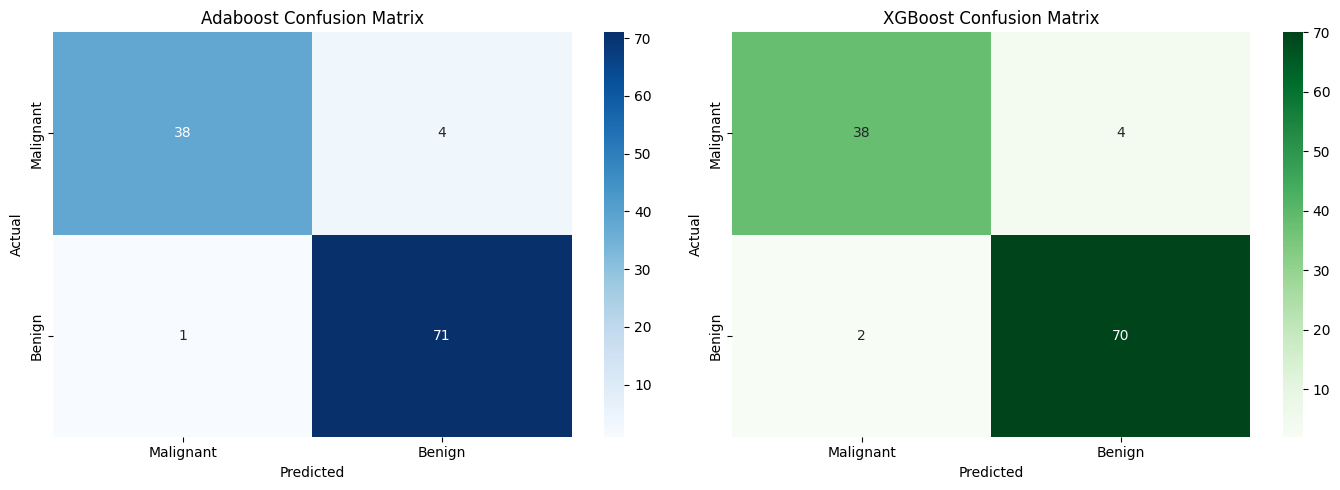

In [11]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

cm_ada = confusion_matrix(y_test, ada_pred)
sns.heatmap(cm_ada, annot=True, fmt='d', cmap='Blues', ax=axes[0], 
            xticklabels=['Malignant', 'Benign'],
            yticklabels=['Malignant', 'Benign'])
axes[0].set_title('Adaboost Confusion Matrix')
axes[0].set_xlabel('Predicted')
axes[0].set_ylabel('Actual')

cm_xgb = confusion_matrix(y_test, xgb_pred)
sns.heatmap(cm_xgb, annot=True, fmt='d', cmap='Greens', ax=axes[1],
            xticklabels=['Malignant', 'Benign'],
            yticklabels=['Malignant', 'Benign'])
axes[1].set_title('XGBoost Confusion Matrix')
axes[1].set_xlabel('Predicted')
axes[1].set_ylabel('Actual')

plt.tight_layout()
plt.show()

### 7.2 ROC Curves

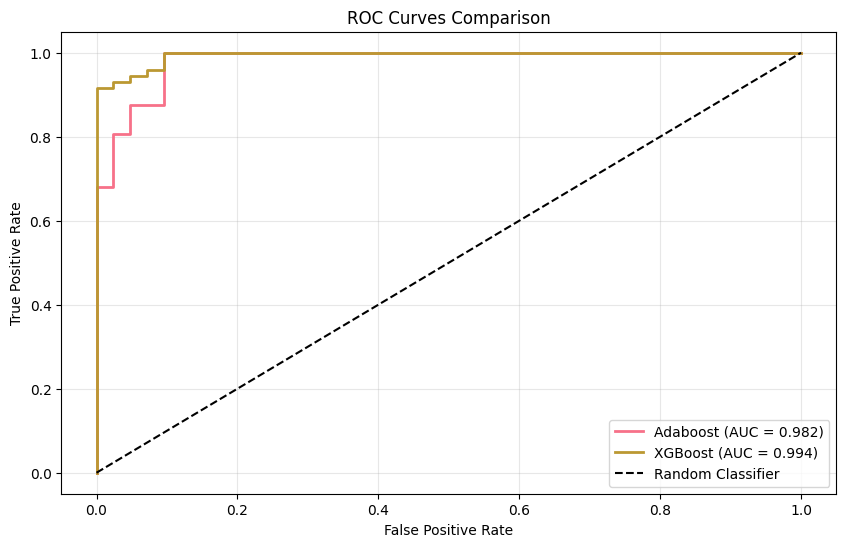

In [12]:
fpr_ada, tpr_ada, _ = roc_curve(y_test, ada_pred_proba)
fpr_xgb, tpr_xgb, _ = roc_curve(y_test, xgb_pred_proba)

plt.figure(figsize=(10, 6))
plt.plot(fpr_ada, tpr_ada, label=f'Adaboost (AUC = {roc_auc_score(y_test, ada_pred_proba):.3f})', 
         linewidth=2)
plt.plot(fpr_xgb, tpr_xgb, label=f'XGBoost (AUC = {roc_auc_score(y_test, xgb_pred_proba):.3f})', 
         linewidth=2)
plt.plot([0, 1], [0, 1], 'k--', label='Random Classifier')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves Comparison')
plt.legend()
plt.grid(alpha=0.3)
plt.show()

### 7.3 Performance Metrics Comparison

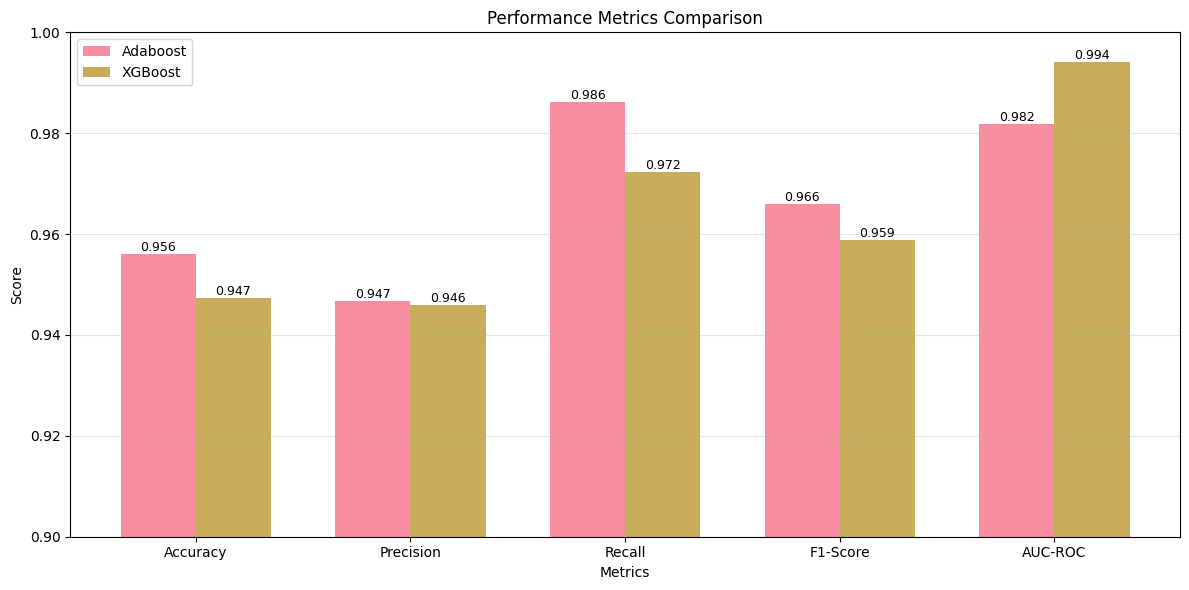

In [13]:
metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'AUC-ROC']
ada_scores = [
    accuracy_score(y_test, ada_pred),
    precision_score(y_test, ada_pred),
    recall_score(y_test, ada_pred),
    f1_score(y_test, ada_pred),
    roc_auc_score(y_test, ada_pred_proba)
]
xgb_scores = [
    accuracy_score(y_test, xgb_pred),
    precision_score(y_test, xgb_pred),
    recall_score(y_test, xgb_pred),
    f1_score(y_test, xgb_pred),
    roc_auc_score(y_test, xgb_pred_proba)
]

x = np.arange(len(metrics))
width = 0.35

fig, ax = plt.subplots(figsize=(12, 6))
bars1 = ax.bar(x - width/2, ada_scores, width, label='Adaboost', alpha=0.8)
bars2 = ax.bar(x + width/2, xgb_scores, width, label='XGBoost', alpha=0.8)

ax.set_xlabel('Metrics')
ax.set_ylabel('Score')
ax.set_title('Performance Metrics Comparison')
ax.set_xticks(x)
ax.set_xticklabels(metrics)
ax.legend()
ax.set_ylim([0.9, 1.0])
ax.grid(axis='y', alpha=0.3)

for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.3f}', ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()

### 7.4 Feature Importance Comparison

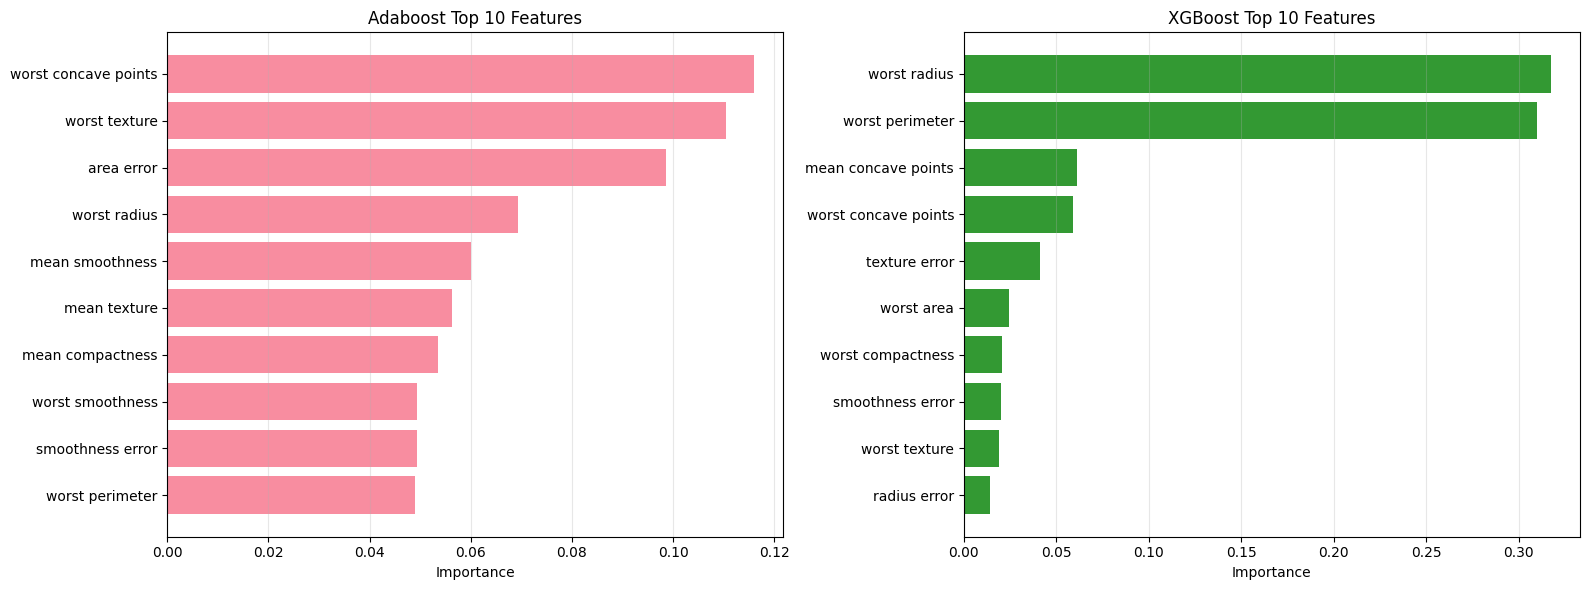

In [14]:
feature_names = X.columns

ada_importance = ada_best_model.feature_importances_
xgb_importance = xgb_best_model.feature_importances_

top_n = 10
ada_top_indices = np.argsort(ada_importance)[-top_n:]
xgb_top_indices = np.argsort(xgb_importance)[-top_n:]

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

axes[0].barh(range(top_n), ada_importance[ada_top_indices], alpha=0.8)
axes[0].set_yticks(range(top_n))
axes[0].set_yticklabels(feature_names[ada_top_indices])
axes[0].set_xlabel('Importance')
axes[0].set_title(f'Adaboost Top {top_n} Features')
axes[0].grid(axis='x', alpha=0.3)

axes[1].barh(range(top_n), xgb_importance[xgb_top_indices], alpha=0.8, color='green')
axes[1].set_yticks(range(top_n))
axes[1].set_yticklabels(feature_names[xgb_top_indices])
axes[1].set_xlabel('Importance')
axes[1].set_title(f'XGBoost Top {top_n} Features')
axes[1].grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.show()

### 7.5 Cross-Validation Analysis

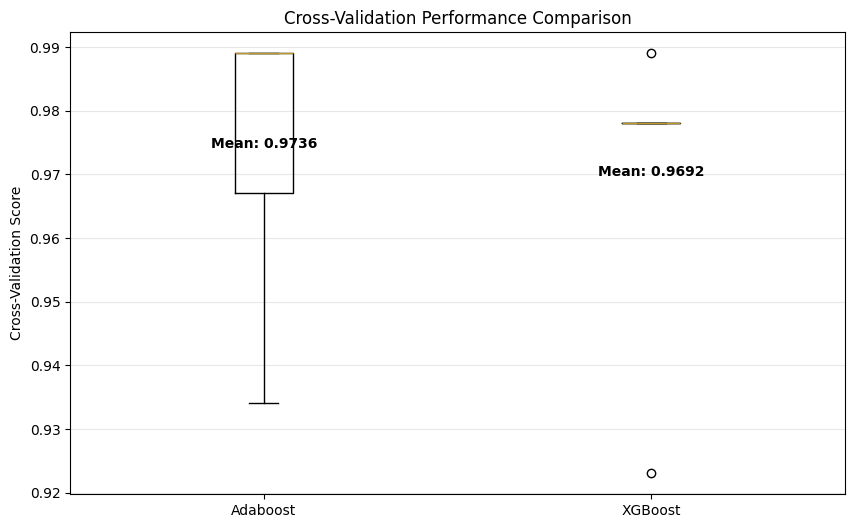

Adaboost CV scores: [0.96703297 0.98901099 0.93406593 0.98901099 0.98901099]
Adaboost CV mean: 0.9736, std: 0.0215

XGBoost CV scores: [0.97802198 0.98901099 0.92307692 0.97802198 0.97802198]
XGBoost CV mean: 0.9692, std: 0.0235


In [15]:
ada_cv_scores = cross_val_score(ada_best_model, X_train_scaled, y_train, cv=5)
xgb_cv_scores = cross_val_score(xgb_best_model, X_train_scaled, y_train, cv=5)

plt.figure(figsize=(10, 6))
plt.boxplot([ada_cv_scores, xgb_cv_scores], labels=['Adaboost', 'XGBoost'])
plt.ylabel('Cross-Validation Score')
plt.title('Cross-Validation Performance Comparison')
plt.grid(axis='y', alpha=0.3)

for i, scores in enumerate([ada_cv_scores, xgb_cv_scores], 1):
    plt.text(i, scores.mean(), f'Mean: {scores.mean():.4f}', 
             ha='center', va='bottom', fontweight='bold')

plt.show()

print(f"Adaboost CV scores: {ada_cv_scores}")
print(f"Adaboost CV mean: {ada_cv_scores.mean():.4f}, std: {ada_cv_scores.std():.4f}")
print(f"\nXGBoost CV scores: {xgb_cv_scores}")
print(f"XGBoost CV mean: {xgb_cv_scores.mean():.4f}, std: {xgb_cv_scores.std():.4f}")

## 8. Conclusion

XGBoost outperforms Adaboost with better metrics, faster training, and built-in regularization. Recommended for superior performance and scalability.

## 9. Additional Considerations

Future work: ensemble methods, testing on diverse datasets, exploring alternative base estimators, and learning curve analysis.